In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from train_cvppp import evaluate

import deepcoloring as dc

%matplotlib inline
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from os import sys, path
directory = path.dirname(path.abspath(__file__))

NameError: name '__file__' is not defined

In order to run this example you need to download dataset https://www.plant-phenotyping.org/datasets-download

In [2]:
#Path to the folder
basepath = "/media/hpc-4_Raid/vkulikov/CVPPP2017_LSC_training/training/A1/"
rgb = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_label.png')])
#Check the names are paired correctly
assert np.array([img[:-7]==lbl[:-9] for img,lbl in zip(rgb,labels)]).all()==True

np.random.seed(1203412412)
indexes = np.random.permutation(len(rgb))
perm_rgb = np.array(rgb)[indexes].tolist()
perm_labels = np.array(labels)[indexes].tolist()

train_data = dc.Reader(perm_rgb[:-10],perm_labels[:-10],2)
valid_data = dc.Reader(perm_rgb[-10:],perm_labels[-10:],2)

In [6]:
net = dc.EUnet(3,6,2,2,2,padding=1,init_xavier=True,use_bn=True,use_dropout=True).to(device)
net = net.load_state_dict(torch.load("model.t7"))

(<matplotlib.figure.Figure at 0x7f5a381f44d0>,
 <matplotlib.figure.Figure at 0x7f5a4c4a3b50>)

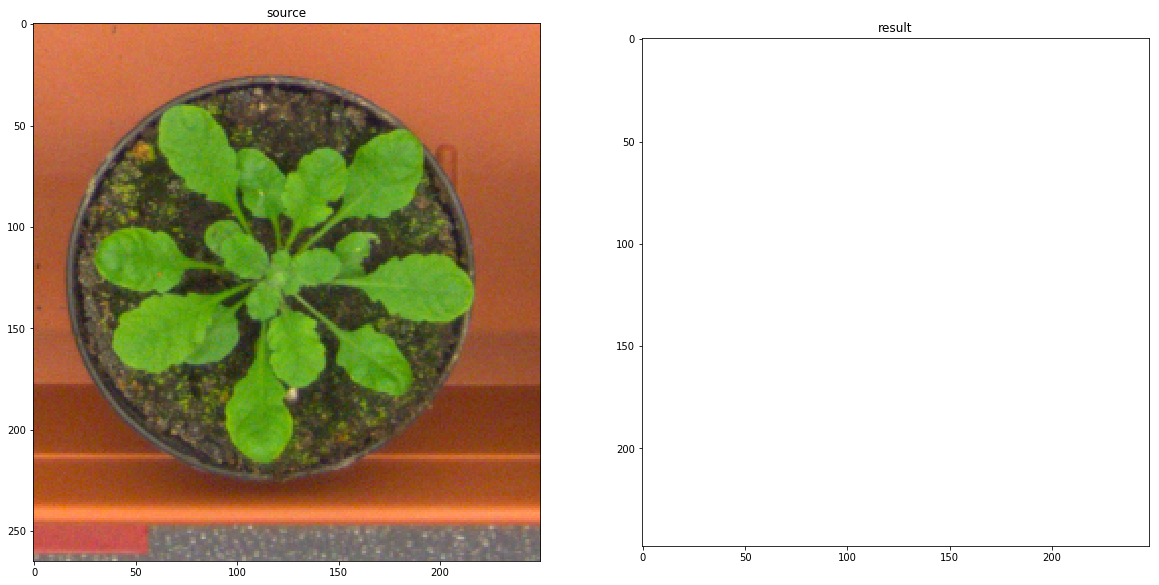

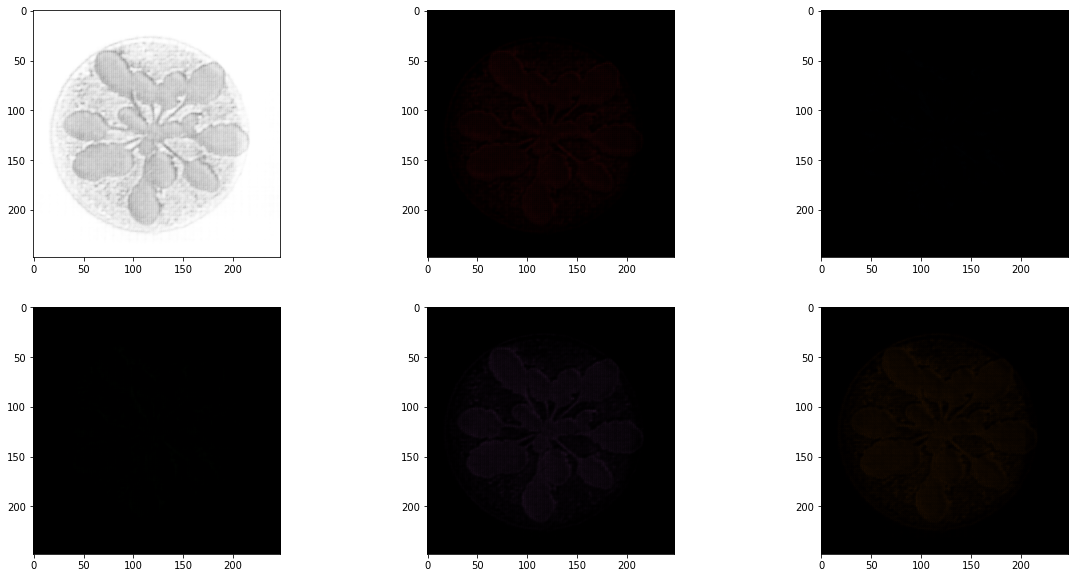

In [9]:
xo, y = valid_data[5]
x = dc.rgba2rgb()(xo, True)
x = dc.normalize(0.5, 0.5, )(x, True)
x = x.transpose(2, 0, 1)[:, :248, :248]

vx = torch.from_numpy(np.expand_dims(x, 0)).to(device)
p = net(vx)
p_numpy = p.detach().cpu().numpy()[0]
dc.visualize(xo,p_numpy)